This code will load the model information, generate the model definition, and run the model estimation using FSL

In [1]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob
import numpy
import nibabel
import nilearn.plotting

from make_event_files_from_json import MakeEventFilesFromJSON
%matplotlib inline
import matplotlib.pyplot as plt


try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
    
results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print 'Using data from',datadir

Using data from /home/vagrant/data


Load the scan and model info, and generate the event files for FSL from the information in model.json

In [2]:
subject='sub00001'
session='ses014'  
# note - we have to use the anatomy from a different session'
subdir=os.path.join(datadir,'ds031', subject, session)
tasknum=2 # n-back

preprocessed_epi = os.path.join(results_dir, "preprocessed_epi_native_space.nii.gz")

scaninfo=json.load(open(os.path.join(subdir,
        'functional/sub00001_ses014_task002_run001_bold.json')))
tr=scaninfo['RepetitionTime']

modelfile=os.path.join(subdir,'model.json')
modelinfo=json.load(open(modelfile))
taskinfo=modelinfo['task%03d'%tasknum]['model001']
evs=taskinfo['Variables']
contrasts=taskinfo['Contrasts']

# get the response onsets
response_onsets=[]

for v in evs.iterkeys():

    if evs[v]['VariableName'].find('_target_ons')>-1:
        for ons in evs[v]['onsets']:
            response_onsets.append(ons[0])

Specify the model.  For the sake of speed we will use a simplified model that treats the study as a blocked design rather than modeling each item separately, but we also model instructions and motor responses; this, it is a hybrid block/event-related design

In [3]:
instruction_onsets=list(numpy.array([68,176,372,2,154,416,24,220,350,112,198,328,46,264,394,90,242,306])-2.0)

info = [Bunch(conditions=['faces-1back',
                          'faces-2back',
                          'scenes-1back',
                          'scenes-2back',
                          'chars-1back',
                          'chars-2back',
                          'instructions',
                          'responses'],
              onsets=[[68,176,372],
                      [2,154,416],
                      [24,220,350],
                      [112,198,328],
                      [46,264,394],
                      [90,242,306],
                      instruction_onsets,
                      response_onsets],
              durations=[[20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [2],
                         [1]])
       ]

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = preprocessed_epi
s.inputs.time_repetition = tr
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

Generate the fsf and ev files using Level1Design

In [4]:
contrasts=[['faces>Baseline','T', 
            ['faces-1back','faces-2back'],[0.5,0.5]],
           ['scenes>Baseline','T', 
            ['scenes-1back','scenes-2back'],[0.5,0.5]],
           ['chars>Baseline','T', 
            ['chars-1back','chars-2back'],[0.5,0.5]],
           ['2back>1back','T', 
            ['faces-1back','faces-2back','scenes-1back','scenes-2back','chars-1back','chars-2back'],[-1,1,-1,1,-1,1,-1,1]],
          ['response>Baseline','T',
           ['responses'],[1]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = tr,
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

INFO:workflow:Executing node f14bb19b5ec9357e65b68ce54e1732ee in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f14bb19b5ec9357e65b68ce54e1732ee
INFO:workflow:Collecting precomputed outputs



ev_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f14bb19b5ec9357e65b68ce54e1732ee/ev_faces-1back_0_1.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f14bb19b5ec9357e65b68ce54e1732ee/ev_faces-2back_0_3.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f14bb19b5ec9357e65b68ce54e1732ee/ev_scenes-1back_0_5.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f14bb19b5ec9357e65b68ce54e1732ee/ev_scenes-2back_0_7.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f14bb19b5ec9357e65b68ce54e1732ee/ev_chars-1back_0_9.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f14bb19b5ec9357e65b68ce54e1732ee/ev_chars-2back_0_11.txt', '/home/vagra

Generate the full set of model files using FEATModel

In [5]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

INFO:workflow:Executing node 4f6170ae9f202b590064fef34e5c4e2a in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4f6170ae9f202b590064fef34e5c4e2a
INFO:workflow:Collecting precomputed outputs



con_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4f6170ae9f202b590064fef34e5c4e2a/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4f6170ae9f202b590064fef34e5c4e2a/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4f6170ae9f202b590064fef34e5c4e2a/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4f6170ae9f202b590064fef34e5c4e2a/run0.png
fcon_file = <undefined>

Visualize the design matrix

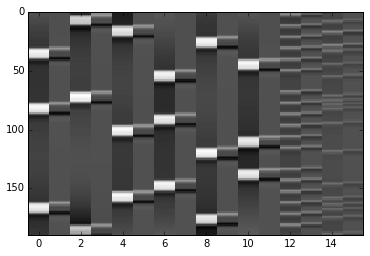

In [6]:
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

Show the correlation matrix for design

<matplotlib.colorbar.Colorbar instance at 0x7f5c5d816320>

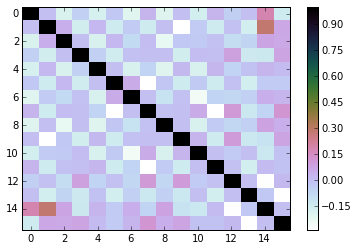

In [7]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.cubehelix_r)
plt.colorbar()

Estimate the model using FILMGLS - this will take a few minutes.

In [8]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=preprocessed_epi,
                    mask_file=os.path.join(results_dir, "mask.nii.gz"))
mask_results.outputs

INFO:workflow:Executing node 2d7b8613d0ef69669f7b069c7c41e294 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/2d7b8613d0ef69669f7b069c7c41e294
INFO:workflow:Collecting precomputed outputs



out_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/2d7b8613d0ef69669f7b069c7c41e294/preprocessed_epi_native_space_masked.nii.gz

In [9]:
filmgls = mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

INFO:workflow:Executing node 235e21f618af0feb302ffa90235c1d83 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83
INFO:workflow:Running: film_gls --noest --rn=results --con=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4f6170ae9f202b590064fef34e5c4e2a/run0.con --in=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/2d7b8613d0ef69669f7b069c7c41e294/preprocessed_epi_native_space_masked.nii.gz --pd=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/4f6170ae9f202b590064fef34e5c4e2a/run0.mat --thr=0.000000
INFO:interface:stdout 2015-08-14T04:45:45.646614:Log directory is: results
INFO:interface:stdout 2015-08-14T04:45:48.854371:paradigm.getDesignMatrix().Nrows()=190
INFO:interface:stdout 2015-08-14T04:45:48.854371:paradigm.getDesignMatrix().Ncols()=16
INFO


copes = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83/results/cope1.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83/results/cope2.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83/results/cope3.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83/results/cope4.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83/results/cope5.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83/results/cope6.nii.gz']
dof_file = /home/vagrant/fmri-analysis-vm/analysis/firstleve

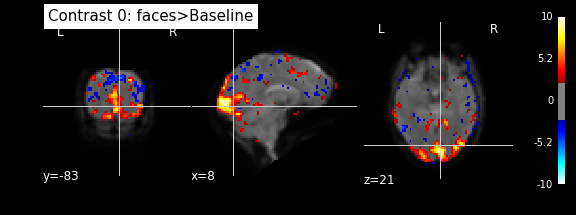

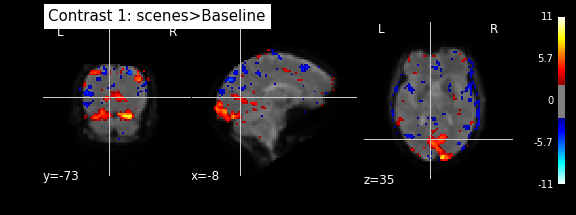

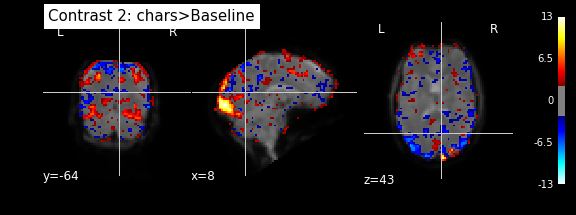

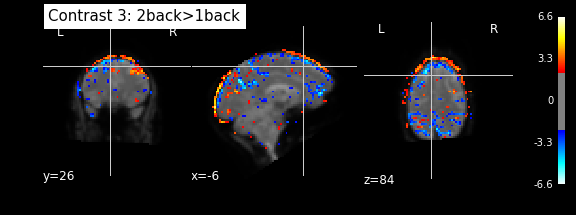

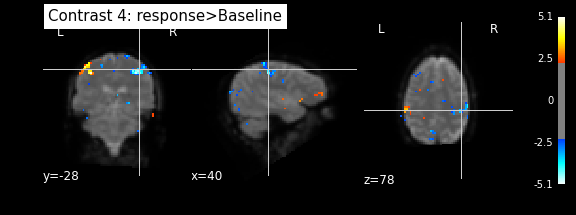

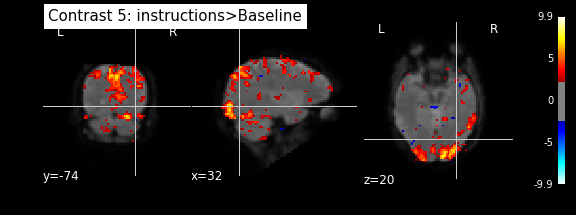

In [10]:
meanimg=nibabel.load(os.path.join(results_dir, "meanbold.nii.gz"))

for contrast_i in range(len(contrasts)):
    nilearn.plotting.plot_stat_map(filmgls_results.outputs.zstats[contrast_i], meanimg,
                                   title='Contrast %d: %s'%(contrast_i,contrasts[contrast_i][0]),
                                   threshold=2.3)

## Move copes, varcopes, and the mask into MNI space

For the group level analysis we need to move results from all subjects into one common MNI space. Let's start with the EPI derived mask (we will use it later for group level mask)

INFO:workflow:Executing node c90015440c6cdfa9705f2b24adf5122d in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/c90015440c6cdfa9705f2b24adf5122d
INFO:workflow:Running: applywarp --in=/home/vagrant/fmri-analysis-vm/analysis/results/mask.nii.gz --ref=/home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz --out=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/c90015440c6cdfa9705f2b24adf5122d/mask_warp.nii.gz --warp=/home/vagrant/fmri-analysis-vm/analysis/results/epi_to_t1_warp.nii.gz --interp=nn
INFO:workflow:Executing node 288fc7e676713e4b4f49c3cf1e53859a in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/288fc7e676713e4b4f49c3cf1e53859a
INFO:workflow:Running: antsApplyTransforms --default-value 0 --input /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-inter

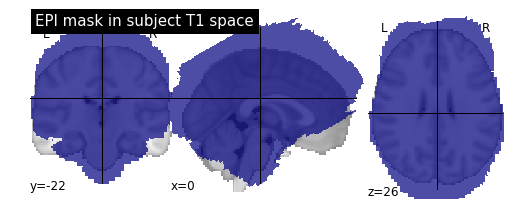

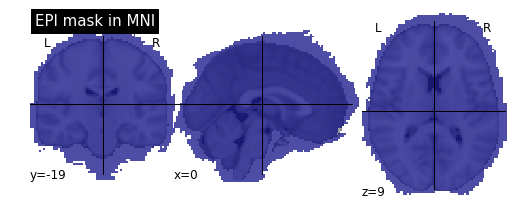

In [11]:
mask_file = os.path.join(results_dir, "mask.nii.gz")
epi_to_t1_warp = os.path.join(results_dir, "epi_to_t1_warp.nii.gz")
t1_to_mni_warp = os.path.join(results_dir, "t1_to_mni_warp.h5")
in_file = mask_file
anat_subject='ses018'
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1_file = os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')

epi_to_t1 = mem.cache(fsl.ApplyWarp)
epi_to_t1_mask_results = epi_to_t1(in_file=in_file,
                                   ref_file=t1_file,
                                   field_file=epi_to_t1_warp,
                                   interp="nn")
nilearn.plotting.plot_roi(epi_to_t1_mask_results.outputs.out_file, title="EPI mask in subject T1 space")

t1_to_mni = mem.cache(ants.ApplyTransforms)
t1_to_mni_mask_results = t1_to_mni(input_image=epi_to_t1_mask_results.outputs.out_file,
                                   reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                   transforms=t1_to_mni_warp,
                                   interpolation="NearestNeighbor")
t1_to_mni_mask_results.outputs
nilearn.plotting.plot_roi(t1_to_mni_mask_results.outputs.output_image, title="EPI mask in MNI")

Now we can use the same procedure for all of the contrast and variance images.

INFO:workflow:Executing node 1961ef709bb71a48eee3e4d51348a891 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/1961ef709bb71a48eee3e4d51348a891
INFO:workflow:Running: applywarp --in=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/235e21f618af0feb302ffa90235c1d83/results/cope1.nii.gz --ref=/home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz --out=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/1961ef709bb71a48eee3e4d51348a891/cope1_warp.nii.gz --warp=/home/vagrant/fmri-analysis-vm/analysis/results/epi_to_t1_warp.nii.gz --interp=spline
INFO:workflow:Executing node 16c49779986997bb7aa1e36282d94ce8 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/16c49779986997bb7aa1e36282d94ce8
INFO:workflow:Running: antsApplyTransforms --d

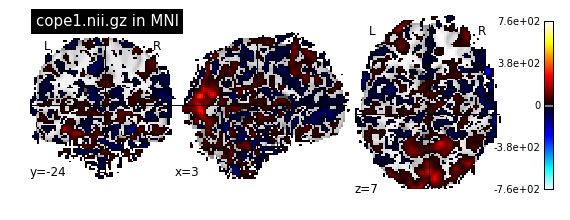

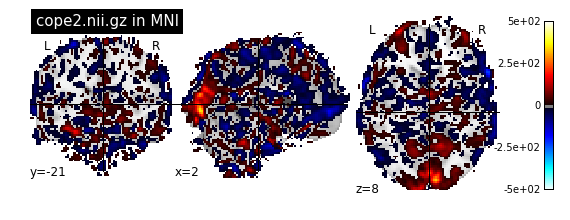

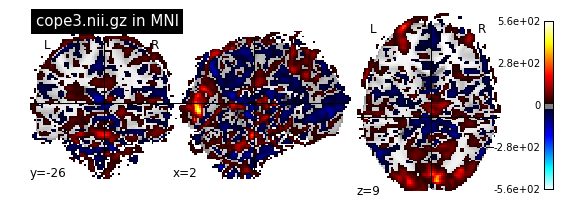

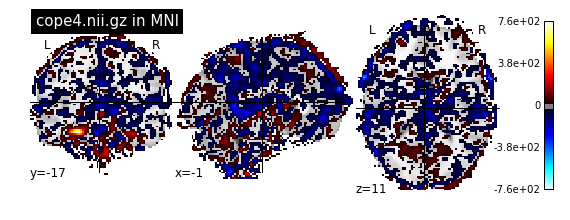

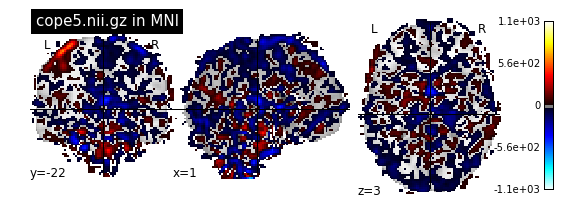

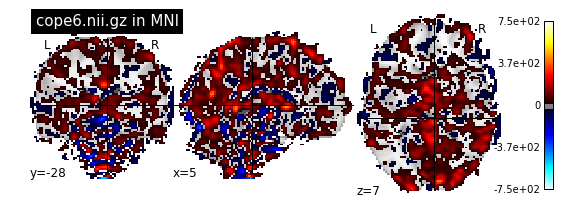

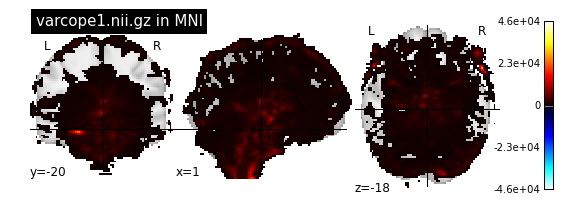

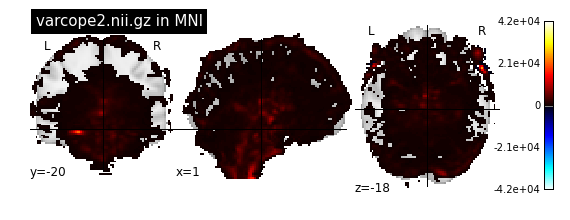

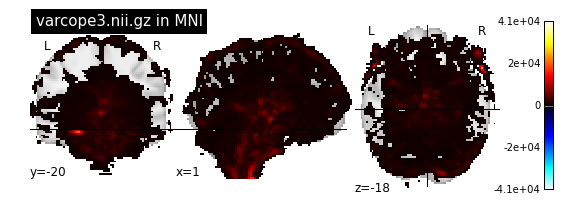

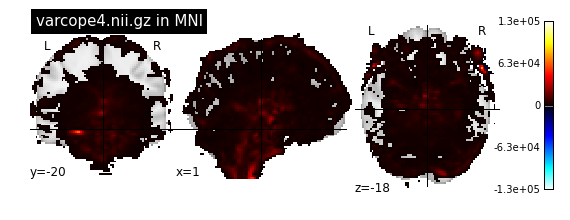

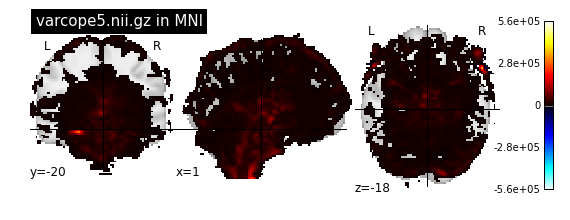

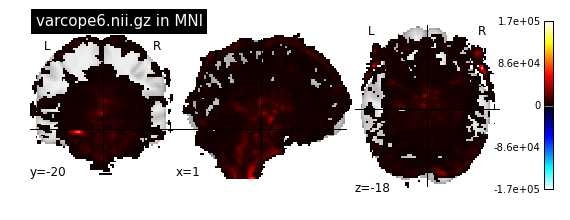

In [12]:
for image in filmgls_results.outputs.copes + filmgls_results.outputs.varcopes:
    _, fname = os.path.split(image)
    epi_to_t1_results = epi_to_t1(in_file=image,
                                       ref_file=t1_file,
                                       field_file=epi_to_t1_warp,
                                       interp="spline")

    t1_to_mni_results = t1_to_mni(input_image=epi_to_t1_results.outputs.out_file,
                                  reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                  transforms=t1_to_mni_warp,
                                  interpolation="BSpline")
    nilearn.plotting.plot_stat_map(t1_to_mni_results.outputs.output_image, title="%s in MNI"%fname, threshold='auto')